In [2]:
import tensorflow as tf
import cv2
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [3]:
#directory
Directory = r"C:\Users\Auni\Documents\SEM8\SECJ4134_SOFTWARE_ENGINEERING_PROJECT_II\FER2013\train"

In [4]:
#classes
Classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [5]:
img_size = 224

In [6]:
# Function to load and preprocess images (for feature extraction)
def load_and_preprocess_image(image_path):
    # Read the image file
    img = tf.io.read_file(image_path)
    
    # Decode the image as an RGB image
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    
    # Resize the image to the target size
    img = tf.image.resize(img, [img_size, img_size])
    
    # Preprocess the image for the base model (e.g., MobileNetV3)
    img = preprocess_input(img)  # Use the correct preprocessing function for the model
    
    return img

In [7]:
#load dataset and labels
image_paths = []
labels = []

for class_name in Classes:
    class_dir = os.path.join(Directory, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(img_path)
            labels.append(Classes.index(class_name))

In [8]:
#split into training and testing sets (80% train, 20% test)
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [9]:
#load MobileNetV3 for feature extraction
base_model = MobileNetV3Large(weights='imagenet', include_top=False, pooling='avg', input_shape=(img_size, img_size, 3))

In [10]:
# Suppress TensorFlow progress bar
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [11]:
# Extract features for training data
batch_size = 64  # Define a batch size

In [12]:
# Wrap the prediction loop in a tf.function for optimization
@tf.function
def predict_batch(batch_images):
    return base_model(batch_images, training=False)

In [13]:
# Extract features for training data
train_features = []
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
# Process training images in batches
for batch_images in train_dataset:
    batch_features = predict_batch(batch_images)  # Predict features for the batch
    train_features.extend(batch_features.numpy())  # Convert to numpy and append

In [15]:
# Convert training features to numpy array
train_features = np.array([feature.flatten() for feature in train_features])

In [16]:
# Print the shape of the extracted features
print(f"Extracted features for training data: {train_features.shape}")

Extracted features for training data: (22967, 960)


In [17]:
# Print the first 5 feature vectors
print(train_features[:5])

[[ 0.02010754  0.          0.95201564 ...  0.00643644 -0.01945353
  -0.01134496]
 [ 0.          0.         -0.00739993 ...  0.20500861  0.82053787
   0.5466354 ]
 [ 0.19885635  0.          0.25998595 ...  0.17039622  0.22806834
   0.        ]
 [-0.00358225  0.0010163   0.01936215 ...  0.13171223  0.2968562
   0.        ]
 [ 0.         -0.00184614  0.         ... -0.02343019  0.01018445
   0.00562764]]


In [18]:
# Extract features for testing data
test_features = []
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(lambda x: load_and_preprocess_image(x), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [19]:
for batch_idx, batch_images in enumerate(test_dataset):
    batch_features = predict_batch(batch_images)  # Predict features for the batch
    test_features.extend(batch_features.numpy())  # Convert to numpy and append

In [20]:
# Convert testing features to numpy array
test_features = np.array([feature.flatten() for feature in test_features])
print(f"Extracted features for testing data: {test_features.shape}")

Extracted features for testing data: (5742, 960)


In [21]:
# Reduce feature dimensionality using PCA
pca = PCA(n_components=100)  # Reduce to 100 dimensions
train_features_reduced = pca.fit_transform(train_features)
test_features_reduced = pca.transform(test_features)

In [22]:
# # Train an SVM classifier
# svm_model = SVC(kernel='linear', probability=True)
# Train a Linear SVM
svm_model = LinearSVC()

In [23]:
svm_model.fit(train_features_reduced, train_labels)

LinearSVC()

Making Predictions on the Test Dataset

In [24]:
# Make predictions on the test set
predicted_labels = svm_model.predict(test_features_reduced)

In [25]:
# Convert predictions to class labels
# `predicted_labels` already contains the predicted class indices from the SVM model
# `test_labels` contains the true class indices
print("Sample Predictions:")
for i in range(10):  # Display the first 10 predictions
    print(f"Predicted: {Classes[predicted_labels[i]]}, True: {Classes[test_labels[i]]}")

Sample Predictions:
Predicted: surprise, True: fear
Predicted: happy, True: happy
Predicted: surprise, True: surprise
Predicted: happy, True: fear
Predicted: surprise, True: surprise
Predicted: happy, True: fear
Predicted: happy, True: angry
Predicted: fear, True: sad
Predicted: happy, True: angry
Predicted: happy, True: neutral


Visualize Predictions

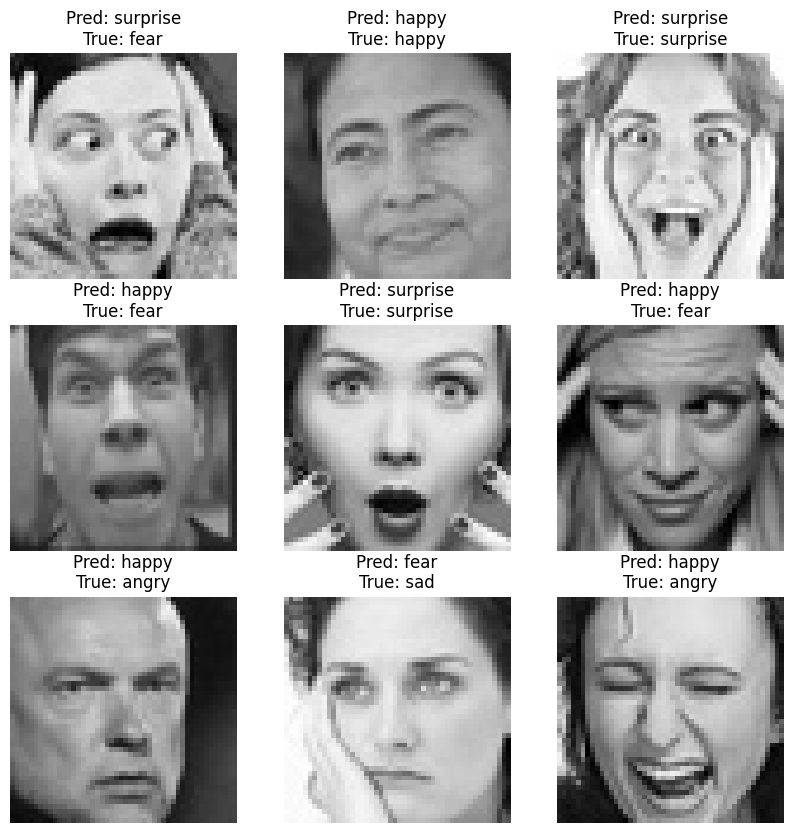

In [28]:
# Visualize predictions
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 images
    ax = plt.subplot(3, 3, i + 1)

    # Load the original test image for visualization
    img_path = test_paths[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper visualization

     # Display the image
    plt.imshow(img)
    predicted_label = Classes[predicted_labels[i]]
    true_label = Classes[test_labels[i]]
    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

In [29]:
# Evaluate the SVM model
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.4723


In [30]:
# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, predicted_labels, target_names=Classes))


Classification Report:
              precision    recall  f1-score   support

       angry       0.43      0.27      0.33       779
     disgust       0.00      0.00      0.00        92
        fear       0.41      0.20      0.27       838
       happy       0.53      0.81      0.64      1474
     neutral       0.44      0.46      0.45       986
         sad       0.38      0.33      0.35       977
    surprise       0.52      0.62      0.56       596

    accuracy                           0.47      5742
   macro avg       0.39      0.38      0.37      5742
weighted avg       0.45      0.47      0.44      5742



c:\Users\Auni\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Auni\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Auni\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

In [32]:
plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

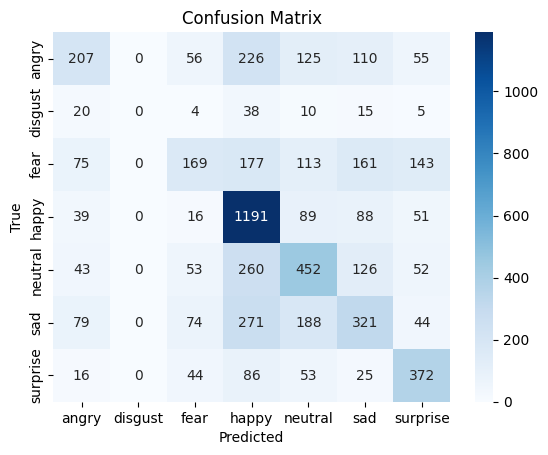

In [33]:
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=Classes, yticklabels=Classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()